## Loading in AMSR-2 Data & CFM data

In [ ]:
from netCDF4 import Dataset
from scipy.interpolate import RegularGridInterpolator
import numpy as np
from pyproj import Proj, transform
import scipy.io as sio
from netCDF4 import Dataset
import pickle
import os

# Frequency we use is 18 GHz 
f = '18'

# Where to find the AMSR2 data 

# Loading in AMSR2 Data from 2013-2018
# -------------
loc = '/Users/mdattler/Desktop/Large_Data_Files/All_AMSR_Data/AMSR_DATA_PICKLE/'
new_z_V = pickle.load(loc+'Data2014_2018_'+f+'V.p')
new_z_H = pickle.load(loc+'Data2014_2018_'+f+'H.p')
new_x = pickle.load(loc+'Data2014_2018_x.p')
new_y = pickle.load(loc+'Data2014_2018_y.p')


# LOAD YOUR OWN AMSR-2 DATA HERE ^
# -------------

# Coordinates of AMSR-2 



# Loading in CFM Ouput 
firndata = Dataset('gsfcv1LarsenC.nc')



## CFM output: oversampling from five-daily to daily
### Goal is to match temporal resolution of AMSR-2 (daily)


In [ ]:
z = firndata['temperature'][:,:,:].shape[2]
depths = np.arange(0,z)


temperature = np.zeros((firndata['temperature'].shape[0],len(days),firndata['temperature'].shape[2]))*np.nan

grain = temperature.copy()*np.nan
lwc = temperature.copy()*np.nan
density = temperature.copy()*np.nan
thickness = temperature.copy()*np.nan
pme = np.zeros((firndata['temperature'].shape[0],len(days)))

for day,date in enumerate(days):
    cfm_day_idx = np.argmin(np.abs(firndata['time']-date))
    start = day-2
    if start<0.:
        start = 0
    end=day+3
    if end > len(days):
        end = -1 
    
    for ind in np.arange(start,end):
        temperature[:,ind,:] = firndata['temperature'][:,cfm_day_idx,:]
        density[:,ind,:] = firndata['density'][:,cfm_day_idx,:]
        lwc[:,ind,:] = firndata['liq. water content'][:,cfm_day_idx,:]
        grain[:,ind,:] = np.sqrt(firndata['grain_size'][:,cfm_day_idx,:])*1e6
        thickness[:,ind,:] = firndata['thickness'][:,cfm_day_idx,:]
        pme[:,ind] = firndata['P-E'][:,cfm_day_idx]
    

## Interpolating onto the AMSR-2 grid (12.5 km x 12.5 km)

In [ ]:
from scipy.interpolate import RegularGridInterpolator

cfm_tbH = np.zeros((len(cfm_x),len(days)))
cfm_tbV = np.zeros((len(cfm_x),len(days)))

for day in np.arange(0,len(days)):
    fV= RegularGridInterpolator((new_x[0,:], new_y[::-1,0]), new_z_V[::-1,:,day].T)
    fH= RegularGridInterpolator((new_x[0,:], new_y[::-1,0]), new_z_H[::-1,:,day].T)

    cfm_tbH[:,day] = fH((cfm_x,cfm_y))
    cfm_tbV[:,day] = fV((cfm_x,cfm_y))
    


## Focusing on a specific point location on the Larsen C: Pt #35

In [ ]:
inProj = Proj(init='epsg:4326') 
outProj = Proj(init='epsg:3412')

lon,lat = transform(outProj,inProj,cfm_x[35],cfm_y[35])

print(lon,lat)

-62.44718842328222 -66.44759395645764


In [ ]:
from smrt import make_snowpack, make_model, sensor_list, water_parameters, make_ice_column
from liquidinversion import grain_inversion_smrt

# Small function to help with continuous nans
import numpy as np
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]


# Creating object grain_inversion_smrt
inv = grain_inversion_smrt(sensor='18V', EM='iba', solver='dort', microstructure='exponential')


# Initial bounds for Correlation Length/Microwave Grain Size
init_bounds = np.asarray([500e-6,1200e-6])

# Top possible values for liquid water content
lwc_top = np.arange(0.,0.02,0.001)


# Allocating arrays
best_lwc_under = CL_filled.copy()*np.nan
best_lwc = CL_filled.copy() * np.nan
best_lwc_over = CL_filled.copy()*np.nan


# Iterating over each day in time series for "point" or #35
for day in np.arange(0,len(days),5):

    # allocating arrays
    difference_under = lwc_top*np.nan  
    difference = lwc_top*np.nan
    difference_over = lwc_top*np.nan  
    

    for ind,lwc in enumerate(lwc_top):
        print(cfm_tbV[point,day])
        good = thickness[point,day,:]>0
        temp = temperature[point,day,:][good]
        gr = grain[point,day,:][good]*1e-6
        dens = density[point,day,:][good]
        th = thickness[point,day,:][good]

        lwc_column = dens.copy()*0.
        lwc_column[0:5] = lwc  


        # Calculate difference between AMSR-2 measurement & modeled with CL/MGS lower by 25 than predicted
        difference_under[ind] = inv.run_smrt_forward(           
            thickness=th,
            temperature=temp,
            grain_guess=CL_filled[day] - 25e-6,
            density=dens,
            estimate_tb=cfm_tbV[point,day],
            liquid_water=lwc_column
        )

        # Calculate difference between AMSR-2 measurement & modeled with CL/MGS at predicted
        difference[ind] = inv.run_smrt_forward(           
            thickness=th,
            temperature=temp,
            grain_guess=CL_filled[day],
            density=dens,
            estimate_tb=cfm_tbV[point,day],
            liquid_water=lwc_column
        )
        # Calculate difference between AMSR-2 measurement & modeled with CL/MGS 25 higher than predicted
        difference_over[ind] = inv.run_smrt_forward(           
            thickness=th,
            temperature=temp,
            grain_guess=CL_filled[day] + 25e-6,
            density=dens,
            estimate_tb=cfm_tbV[point,day],
            liquid_water=lwc_column
        )

    difference_idx_under = np.nanargmin(np.abs(difference_under))
    best_lwc_under[day] = lwc_top[difference_idx_under]
    difference_idx_over = np.nanargmin(np.abs(difference_over))
    best_lwc_over[day] = lwc_top[difference_idx_over]
    difference_idx = np.nanargmin(np.abs(difference))
    best_lwc[day] = lwc_top[difference_idx]






/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


(2014, 2018.4)

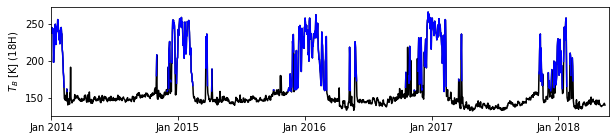

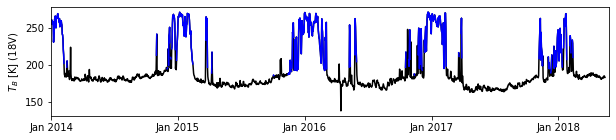

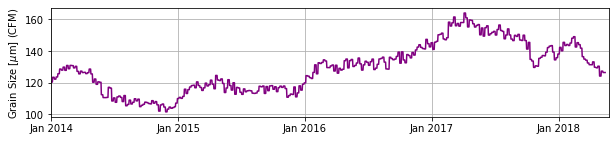

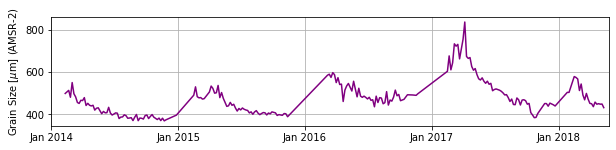

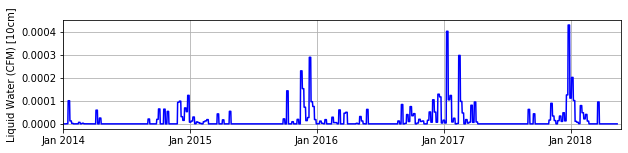

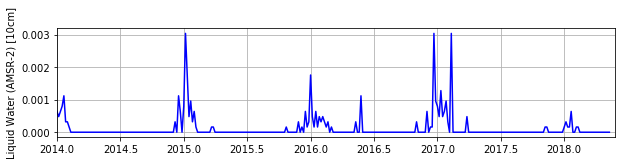

In [ ]:
import matplotlib.pyplot as plt

dayofyear=days-np.floor(days)

plt.figure(figsize=(10,2))
plt.xlim([2014,2018.4])
tbH_restrict = cfm_tbH[35,:].copy()

# Restrict loosely to austral winter 
tbH_restrict[dayofyear>250./365.] = np.nan
tbH_restrict[dayofyear<150./365.] = np.nan

# Creating 3 standard deviation bar for melt thresholding from austral wintertime averaging
avg = np.nanmean(tbH_restrict)
stdev = np.nanstd(tbH_restrict)
threshold = np.zeros(cfm_tbH[35,:].shape)+avg+3*stdev
cfm_tbH_melt = cfm_tbH[35,:].copy()
cfm_tbH_melt[cfm_tbH_melt<threshold] = np.nan


# Plotting AMSR-2 Brightness Temperature: 18H
plt.plot(np.arange(0,len(cfm_tbH[35,:]))/365.+2014.,cfm_tbH[35,:],'k-')
# Plotting AMSR-2 Brightnesss Temperature: 3 standard deviation threshold
plt.plot(np.arange(0,len(cfm_tbH[35,:]))/365.+2014.,cfm_tbH_melt,'b-')
plt.grid()
plt.xticks(np.arange(2014,2019), ['Jan 2014','Jan 2015','Jan 2016','Jan 2017','Jan 2018','Jan 2019'],fontsize=10)
plt.ylabel(r'$T_B$ [K] (18H)')



# Calculating threshold, but for 18V frequency
plt.figure(figsize=(10,2))
cfm_tbV_melt = cfm_tbV[35,:].copy()
cfm_tbH_melt_copy = cfm_tbH[35,:].copy()
cfm_tbV_melt[cfm_tbH_melt_copy<threshold] = np.nan
cfm_tbV_dry = cfm_tbV[35,:].copy()
cfm_tbV_dry[cfm_tbH_melt_copy>threshold] = np.nan

# Plotting brightnesss temperatures, but for 18H frequency 
plt.plot(np.arange(0,len(cfm_tbH[35,:]))/365.+2014.,cfm_tbV[35,:],'k-')
plt.plot(np.arange(0,len(cfm_tbH[35,:]))/365.+2014.,cfm_tbV_melt,'b-')
plt.xticks(np.arange(2014,2019), ['Jan 2014','Jan 2015','Jan 2016','Jan 2017','Jan 2018','Jan 2019'],fontsize=10)
plt.grid()
plt.xlim([2014,2018.4])
plt.ylabel(r'$T_B$ [K] (18V)')



# Plotting Grain size from CFM
plt.figure(figsize=(10,2))
plt.plot(np.arange(0,len(cfm_tbH[35,:]))/365.+2014.,np.nanmean(grain[35,:,:],axis=1),'-',color='purple')
plt.xticks(np.arange(2014,2019), ['Jan 2014','Jan 2015','Jan 2016','Jan 2017','Jan 2018','Jan 2019'],fontsize=10)
plt.grid()
plt.xlim()
plt.ylabel(r'Grain Size [$\mu$m] (CFM)')
plt.xlim([2014,2018.4])


# Predicted correlation length/MGS 
plt.figure(figsize=(10,2))
plt.plot(days2[~np.isnan(predicted_CL)],predicted_CL[~np.isnan(predicted_CL)]*1e6,'-',color='purple')
plt.xticks(np.arange(2014,2019), ['Jan 2014','Jan 2015','Jan 2016','Jan 2017','Jan 2018','Jan 2019'],fontsize=10)
plt.grid()
plt.ylabel(r'Grain Size [$\mu$m] (AMSR-2)')
plt.xlim([2014,2018.4])


# Plotting LWC from CFM (upper 10 cm)
lwc[lwc<-1] = 0.
plt.figure(figsize=(10,2))
days2 = np.arange(0,len(cfm_tbH[15,:]))/365.+2014.
plt.plot(days2,np.sum(lwc[35,:,:5],axis=1),'b-')
plt.xticks(np.arange(2014,2019), ['Jan 2014','Jan 2015','Jan 2016','Jan 2017','Jan 2018','Jan 2019'],fontsize=10)
plt.grid()
plt.ylabel(r'Liquid Water (CFM) [10cm]')
plt.xlim([2014,2018.4])

# Plotting liquid water content, as predicted by AMSR-2 (10 cm)
plt.figure(figsize=(10,2))
plt.plot(days2[~np.isnan(best_lwc)],best_lwc[~np.isnan(best_lwc)]*0.16,'b-')
plt.grid()
plt.ylabel(r'Liquid Water (AMSR-2) [10cm]')
plt.xlim([2014,2018.4])

